In [1]:
#!pip install transformers
#!pip install datasets
#!pip install fastai
#!pip install ohmeow-blurr

In [2]:
#!pip install seqeval

# Skript3: Model Finetuning für Text-Klassifizierung mit germaneval2019 Task2 -Subtask1 mit Fast-AI

Dieses Notebook beschreibt das Training eines Text-Klassifizierungsmodells für den Datensatz GermEval 2019 Task2 -Subtask1.
Es wird ein BERT - Modell mit der Fast-AI und der Blurr Bibliothek trainiert. Das Training erfolgt nach dem gleichen Split wie es der Shared Task 2019 vorgab.

In [3]:
# Importieren der Hugging Face Datesets Bibliothek
import datasets
from fastai.text.all import *
from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /home/cbartels/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Parameter für die Scriptsteuerung:
# die Task für die das Modell trainiert werden soll
task = "task1"
# das zu verwendende pretrained Transformer Modell
model_checkpoint = "deepset/gbert-base"
# die Trainingsbatchsize
batch_size = 4

In [5]:
# Festlegen weiterer Scriptparameter anhand der gewählten Task:
if task == "task1":
    num_labels = 2
    y_col = "task1_label"
else:
    num_labels = 4
    y_col = "task2_label"

## Herunterladen und Bereitstellen der Transformers Komponenten.
Dafür wird lediglich der gewünschte model_checkpoint an die Methode `BLURR_MODEL_HELPER.get_hf_objects` übergeben. Diese beschafft das entsprechende Model und die zugehörigen Daten wie den Tokenizer für die gewählte Task:

In [6]:
hf_task = HF_TASKS_AUTO.SequenceClassification
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

## Preprocessing des Datasets

In [7]:
import pandas as pd

Zunächst werden  alle Trainingsdaten aus dem GermEval2019 Dataset zu einem Pandas Dataframe zusammengefügt:

In [8]:
data1=pd.read_csv("../datasets/germeval2019/train_valid/germeval2018.test_.txt",sep='\t', header=None,quoting=3)
data2=pd.read_csv("../datasets/germeval2019/train_valid/germeval2018.training.txt",sep='\t', header=None,quoting=3)
data3=pd.read_csv("../datasets/germeval2019/train_valid/germeval2019.training_subtask1_2_korrigiert.txt",sep='\t',quoting=3, header=None)
data_all = data1.append([data2,data3])
data_all.columns = ["text","task1_label","task2_label"]
data_all.head()

,text,task1_label,task2_label
0,"Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺",OTHER,OTHER
1,"@Tom174_ @davidbest95 Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen.",OTHER,OTHER
2,"#Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!",OTHER,OTHER
3,„Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort,OTHER,OTHER
4,@umweltundaktiv Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.,OFFENSE,ABUSE


Verarbeiten des Testdatensatzes in einen Dataframe:

In [9]:
data_test = pd.read_csv("../datasets/germeval2019/test/germeval2019GoldLabelsSubtask1_2.txt",delimiter="\t",quoting=3, header=None)
data_test.columns = ["text","task1_label","task2_label"]
# Fügt eine Spalte is_valid ein die eine Zeile makiert als Teil des Validationsets
data_test['is_valid']=True
dummy_row ={'text':'dummy','task1_label':'OTHER','task2_label':"OTHER",'is_valid':False}
# Einfügen der Dummyzeile, sodass im Anschluss im DataBlock der ColSplitter verwendet werden kann und das Testset komplett ist
data_test = data_test.append(dummy_row,ignore_index=True)
data_test.tail()

,text,task1_label,task2_label,is_valid
3027,"Um es klar zu stellen: Ich will hier kein White-Washing betreiben (hätte er die Unterstützung der Kurden gegen die Entente-Mächte wie versprochen belohnt, wäre etliches Leid in der Folge erspart geblieben). Just my 2 cents.",OTHER,OTHER,True
3028,"Und dann habe ich da noch die McArthur-Briefe im Sinn. Alles in allem ist mein Eindruck der, dass er damals moderner war als heutige Kemalisten.",OTHER,OTHER,True
3029,al sehen wer der Ersatzmann wird. Hier könnte man ggf. die aktuelle Richtung des VS korrigieren. Erfahrungsbedingt habe ich da etliche Zweifel.,OTHER,OTHER,True
3030,@JKasek Oder die Bäume. Bin mal in 'nem Wald spazieren gegangen und so'n Baum griff mich doch glatt mit 'nem Zapfen an. Bin noch mal mit meinem Leben davon gekommen.,OTHER,OTHER,True
3031,dummy,OTHER,OTHER,False


## Erstellen der DataLoader via DataBlock API

Um die Trainingsdaten in das Modell zu füttern, wird in Fast-AI ein DataLoader benötigt. Dieser kann mit der DataBlock API erstellt werden. Hierfür übergibt man dem Konstruktur die entsprechenden Blöcke und Informationen darüber, wie die x und y Variable aus den Datensätzen zu ermitteln sind.\
Der `HF_TextBlock` wird verwendet, weil die x-Variable roher Text ist. Der Block kümmert sich um die Anreicherung und Tokenisierung der Eingabedaten des Modells. Dafür wird automatisch der zugehörige Tokenizer der Transformerarchitektur verwendet.\
Der zweite Block bestimmt die Natur der y-Variable. Da es sich hier um ein Klassifizierungsproblem handelt, wird der `CategoryBlock` verwendet. Dieser wandelt die Inhalte der Labelspalte automatisch in entsprechende Kategorieencodings um.\
Durch die Parameter `get_x` und `get_y` kann dem `DataBlock` mitgeteilt werden, wie er die x- und y-Variable beschaffen soll. In diesem Fall wird dies mit einem `ColReader` durchgeführt, welcher die entsprechenden Werte aus der Spalte `text` und der Labelspalte extrahiert.\
Der `splitter` Parameter bestimmt, wie der Datensatz aufgeteilt werden soll. Der gewählte Splitter ist der `RandomSplitter`. Dieser ordent die Daten zufällig dem Trainings und dem Validierungsset zu. Die gewählte Aufteilung ist 80 % Trainingsset und 20 % Validierungsset.


In [10]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=RandomSplitter(valid_pct=0.2, seed=42))

Mithilfe der `summary` Methode kann man einen Problelauf des DataBlock starten. Die Ausgabe gibt Auskünfte darüber, was während der Verabeitung der Daten passiert und ob es zu Fehlern kommt. 

In [11]:
dblock.summary(data_all)

Setting-up type transforms pipelines
0                                          Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺   
1     @Tom174_ @davidbest95 Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen.   
2                           #Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!   
3                                                                                                     „Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort   
4                                              @umweltundaktiv Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.   
...                                                                                                         

Im Anschluss kann der `DataLoader` für die Trainingsdaten erzeugt werden. Die verwendete Batch Size liegt bei 4 aufgrund der begrenzten Speicherkapazitäten der verwendeten GPU.

In [12]:
dls =  dblock.dataloaders(source=data_all,bs=batch_size)

Wie mit jedem `DataLoader` in Fast-AI kann auch hier ein Beispiel Batch visualisiert werden. Dies wird mit der Methode `show_batch` gestartet.

In [13]:
dls.show_batch(dataloaders=dls)

,text,category
0,"@ _ Migraene _ @ Grace30714933 @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ CoYoSilver @ ph _ phanuel @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ bine1007 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit @ Kabra66 Ist über den Punkt. | LBR | Wer als weißer westlicher Mann jemals wieder einer westlich weißen Frau vertraut... | LBR | Das wird nicht wieder weggehen, sich tief in die Seele einbrennen. | LBR | Wer will schon solche illoyalen Frauen haben? | LBR | "" Vergewaltigungsmaterial ""? | LBR | So sehen sie die Horden.",OFFENSE
1,"@ oadiakosmos @ Fjordspringer @ 3rd _ stone _ f _ sun @ AlfredAndPaul @ Schockadin @ Schnubb36 @ gselsbaer @ transsimian @ TomBell46959788 @ KosmosOadia @ druzim @ DasEbenbild @ _ Apuleius @ karlrahner _ sj @ veronikusz @ LadyLeliana @ VJanusch @ HELMA _ _ D @ ifw _ recht @ gbs _ org Du kannst doch gerne das glauben was du glauben möchtest, dass will dir doch keiner verbieten. Ich interessiere mich aber dafür, warum jemand so etwas heute noch glaubt. Leider konntest du mir bisher keine zufriedenstellende Antwort liefern.",OTHER
2,"@ machtjanix23 @ teite99 @ Norbinator2403 @ ennof _ @ AthinaMala @ troll _ putin @ NancyPeggyMandy @ petpanther0 @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz Bist voll im Stress, was, soviele böse Leute um Dich und soviel Text, Dein Zynismus lässt auch langsam nach - was ist los?",OTHER
3,"@ ChristophColla2 @ peter _ simone @ 65 _ jani @ jusos @ gruene _ jugend So ist es, statt auf den Balkon mit Lindner und Dobrinth belanglosen Mist zu quatschen, hätte man lieber an die Menschen in Deutschland denken sollen, als an die Posten zu denken und sich fast bis zu Unkenntlichkeit der Union anzubiedern, Frau Peters, öfters mal die Klappe halten!",OTHER


Um das Modell im Anschluss des Trainings mit den ungesehenen Testdaten prüfen zu können, müssen diese ebenfalls durch einen `DataLoader` zur Verfügung gestellt werden. Dafür wird ein weiterer `DataBlock` erzeugt, der als Blaupause für den `DataLoader` dienen wird. Der folgende `DataBlock` unterscheidet sich nur im gewählten `splitter` vom vorherigen. Der `ColSplitter` ermöglicht es, die Datensätze eines DataFrames automatisch nach dem Inhalt der Spalte `is_valid` aufzuteilen. Dabei wird jeder Datensatz dem Validierungsset zugeordnet, der den Wert `True` in dieser Spalte enthält.

In [14]:
blocks_test = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())
dblock_test = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader(y_col), splitter=ColSplitter())

In [15]:
dls_test = dblock_test.dataloaders(source=data_test,bs=batch_size)

Ausgabe eines Beispielbatches aus dem Testset:

In [16]:
dls_test.valid.show_batch(dataloaders=dls_test)

,text,category
0,"@ pozelt @ BR24 Des is koa Lebakassemme ned. Moch dei Aung auf, des is a Lebakaskrapfn! | LBR | Ja, spinn i denn? BLASPHEMIE! < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 > < U + 0001F621 >",OTHER
1,"@ MENA _ WATCH @ vonBeutelratte @ Ski3989 @ palactnet @ stefanolix @ _ lnnen _ WT @ SDGMasterglass @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva Habe ich nie getan, sie dreister Lügner. Ich wies darauf hin, dass der Zionismus die jüdische Emanzipationsbewegung schwächte & amp ; so eine positive Entwicklung in Osteuropa ABSICHTLICH verhinderte. Herzls Argument war, die \ "" "" revolutionären jüdischen Massen \ "" in die Kolonie abzuleiten",OFFENSE
2,"@ vonBeutelratte @ MENA _ WATCH @ palactnet @ stefanolix @ _ lnnen _ WT @ SDGMasterglass @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva Wo genau hab ich ein Wort gegen \ "" "" die Juden \ "" gesagt? Im Gegensatz zu Antisemiten und Zionisten sind das für mich ganz gewöhnliche Menschenwie sie & amp ; ich. | LBR | Ich dachte, sie seien schlau genug, zwischen eine Religion und einer sie mißbrauchenden politischen Ideologie zu unterscheiden.",OTHER
3,"@ MENA _ WATCH @ _ lnnen _ WT @ SDGMasterglass @ vonBeutelratte @ Fleischauge @ palactnet @ stefanolix @ Ilona _ GR _ DE @ czsystuvx @ Netzengel @ TiloJung @ JungNaiv @ guyelster @ benabyad @ GreatReturnMa @ UNGeneva @ TwitterSupport Das ist keine Verschwörungstheorie, sondern eine persönliche Erfahrung mit den Lobbyisten der zionistischen Kolonie, die eine Querfront von der LINKEN bis in die AfD bilden... Aber was erkläre ich das 2 Losern, die von so einem Lobbyisten durchgefüttert werden?",OFFENSE


#### Exploration der verarbeiteten Daten

Wie sehen nun die Daten aus, die das Modell füttern? Das kann herausgefunden werden, indem man sich vom `DataLoader` einen Batch geben lässt:

In [17]:
b = dls.one_batch()
b

({'input_ids': tensor([[  102, 17329,  2032,  ...,   169,   566,   103],
          [  102, 17329, 17750,  ...,     0,     0,     0],
          [  102, 17329,  3032,  ...,     0,     0,     0],
          [  102, 17329,  6138,  ...,     0,     0,     0]], device='cuda:0'),
  'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')},
 TensorCategory([0, 1, 1, 1], device='cuda:0'))

Man sieht den klassischen Aufbau des Inputs. Dieser besteht aus den `input_ids`, den `token_type_ids`, der `attention_mask` und Tensor Kategorien für das y-Label. Auch hier ist die Batchsize von 4 erkennbar, denn es liegen für jedes Attribut von `b` 4 Listen oder Werte vor. Jede einen zusammengehörigen Datensatz.

In [18]:
len(b),len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1]) 

(2, 4, torch.Size([4, 336]), 4)

Mithilfe der `input_ids` und dem `hf_tokenizer` können die Tensoren ebenfalls wieder in ihre Textform decodiert werden:
- Es ist erkennbar, dass die BERT typischen Special Tokens nun in der Sequenz enthalten sind
- Ebenfalls wurden bei Bedarf Padding Tokens eingefügt

In [19]:
hf_tokenizer.decode(b[0]['input_ids'][1])

'[CLS] @ Trinchen312 @ bine1007 @ Grace30714933 @ _ Migraene _ @ CoYoSilver @ ph _ phanuel @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit Nein. Geht so nicht in einem großen Thread. Musst Dich da mehr zügeln. | LBR | Das ist dann zwischen euch beiden. | LBR | Bitte ausserhalb. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

## Finetuning des Modells

Es kann nun der Fast-AI `Learner` erzeugt werden. Für die Kompatibilität mit der Transformer Architektur muss das Modell mit dem `HF_BaseModelWrapper` gewrappt werden. Dem `Learner` wird der Trainings-DataLoader, die Modellarchitektur, die Optimierungsfunktion, die Lossfunktion, die zu berechnenden Metriken sowie für die Kompatibilität noch Callbacks und Modellsplitter aus der Blurr Bibliothek.

In [48]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

In [49]:
learn.create_opt()

In [50]:
learn.freeze()

Mit der Methode `learn.blurr_summary()` kann man sich eine Zusammenfassung zum Modell anschauen. Der Bericht enthält Informationen zum Aufbau des Modells sowie über die Anzahl der Parameter und ob diese trainierbar sind. Da das Modell gefroren wurde kann nur der finale Layer sowie die LayerNorm der darunter liegenden Layer trainiert werden.

In [51]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 4 x 336)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 336 x 768       
Embedding                                 23886336   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
      

Der Report zeigt an, dass im eingefrorenen Zustand nur 39938 von 109929218 Parametern trainiert werden.

#### Finden einer guten Learning Rate

Durch die Integration mit Fast-AI kann nun auch der integrierte Learning Rate Finder genutzt werden:

0.0005248074419796466

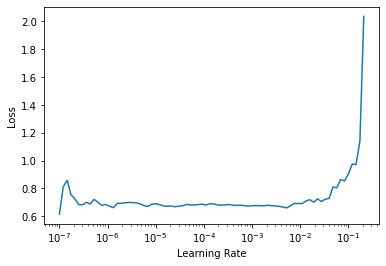

In [52]:
lr_min, _ = learn.lr_find(suggestions=True)
lr_min

Anschließend kann das Training über die `fit_one_cycle` Methode gestartet werden. <br>
Hierfür wird zunächst nur der oberste Layer des Modells trainiert, da die anderen eingefroren wurden.

In [53]:
learn.fit_one_cycle(1,lr_max=lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.442282,0.444546,0.792182,0.745191,0.786967,0.757508,02:17


Nach nur einer Epoch erreicht das Modell bereits eine Accuracy von 79,21 %.

Über das `Learner` Objekt kann man sich anschließend ein paar Beispiel Vorhersagen anzeigen lassen:

In [55]:
learn.show_results(learner=learn)

/home/cbartels/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,category,target
0,@ CoYoSilver @ Grace30714933 @ RalfTHeuer @ Venum27004632 @ chris _ 98763 @ ph _ phanuel @ ChisNoria @ assassina36 @ wellejena @ Bibby182 @ bine1007 @ Iamcovar @ AufgewachteWelt @ EngelGert @ Lukas64F @ Ron1872 @ Ungebeten1 @ PTroll3 @ _ Apuleius @ LouisPeterle @ machata9 @ Ich _ hake _ nach @ n59 _ puppche @ KoyamaMichi @ Cherylli18 @ BoteDesUnrechts @ ASiegwart @ freitweeter @ _ Migraene _ @ OdmantSuperstar @ Lanyihunter1 @ smuelle26677552 @ MaXanonymous @ Johannes135 @ FredKrger2 @ Connybub @ heidi1274 @ pseudros @ Strandvogt3 @ MadameSchwarzi @ Hausfrau4ever @ Robert19594 @ Invictu53409591 @ Vigilant _ _ A @ estathor @ Metalwilli @ willplaat @ 2018Wahrheit @ Kabra66 Vielleicht die Relativierung des Abtötens deutscher Jugendlicher durch vor die Gleise schubsen. | LBR | Durch Scheinflüchtlinge. | LBR | Deutsche Leben sind wertlos gestellt. Wann baumeln die ersten Verantwortlichen endlich an den Laternen?,OFFENSE,OTHER
1,"@ Schnubb36 @ 3rd _ stone _ f _ sun @ Schockadin @ oadiakosmos @ Fjordspringer @ gselsbaer @ transsimian @ AlfredAndPaul @ TomBell46959788 @ KosmosOadia @ druzim @ DasEbenbild @ _ Apuleius @ karlrahner _ sj @ veronikusz @ LadyLeliana @ VJanusch @ HELMA _ _ D @ ifw _ recht @ gbs _ org Dir ist aber schon bekannt wer seit etlichen Jahren in unserer Regierung das Sagen hat? Kleiner Tipp die Partei fängt mit "" C "" wie "" christlich "" an. Beim Amtseid wurde auch auf Gott geschworen. Also ist deine Frage mit JA zu beantworten.",OTHER,OTHER
2,"@ SJW _ MadBunny @ troll _ putin @ machtjanix23 @ Steffmann45 @ petpanther0 @ mastermikeg @ Norbinator2403 @ ennof _ @ AthinaMala @ NancyPeggyMandy @ info2099 @ lifetrend @ ThomasGBauer @ SchmiddieMaik @ charlie _ silve @ NoHerrman @ willjrosenblatt @ feldenfrizz @ nasanasal @ _ macmike @ ellibisathide @ MD _ Franz @ sjw Seit diese Pfosten sich gestern eingeschaltet hatten, ging es mit dem Niveau bergab - wir sprachen gestern über FEMA - das ist lang her - und die Nerven liegen blank, der Klugscheißer wegen.",OFFENSE,OTHER
3,"Liebe Kollektive von | LBR | @ linketshirts | LBR | @ BlackMosqCrew | LBR | @ TrueRebel _ Store | LBR | @ anarchismus _ at | LBR |... bei euch zu bestellen fühlt sich jedes Mal gut, richtig und wichtig an... < U + 0001F5A4 > < U + 2764 > < U + 270A > < U + 0001F3FF > < U + 2764 > < U + 0001F5A4 > | LBR | Aber : Warum finde ich keine ( male - ) Shirts mit V - Ausschnitt bei euch? < U + 0001F628 > < U + 0001F630 >",OTHER,OTHER


#### Ausprobieren der Vorhersage eigener Beispiele
Sobald man ein trainiertes Modell hat, kann man dieses via `blurr_predict` Vorhersagen treffen lassen. Hierfür muss man wie bei der Hugging Face Transformer Pipeline nur einen String übergeben und erhält als Ergebnis die Vorhersage des Modells zurück.

In [33]:
learn.blurr_predict('Du bist eine dumme Sau!')

[(('OFFENSE',), (#1) [tensor(0)], (#1) [tensor([0.8704, 0.1296])])]

In [34]:
learn.blurr_predict("Mensch ist das ein schönes Wetter draußen @CarstenBartelt")

[(('OTHER',), (#1) [tensor(1)], (#1) [tensor([0.0459, 0.9541])])]

#### Trainieren der tieferen Layer
Um auch die tieferen Layer des Modells trainieren zu können, muss es zunächst unfreezed werden:

In [56]:
learn.unfreeze()

Anschließend kann man wieder den Learning Rate Finder nutzen, um den LR Parameter einzustellen:

3.311311274956097e-07

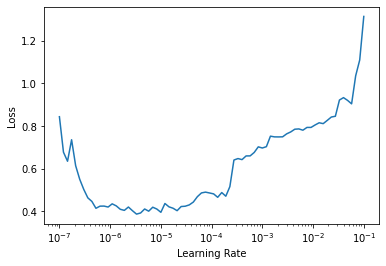

In [58]:
lr_min, _ = learn.lr_find()
lr_min

Die LR für den ersten Layer des Modells wird auf `lr_min` gestellt. Der letzte Layer wird mit einer LR von 1E-4 trainiert. Alle Layer dazwischen werden mit einer LR zwischen `lr_min` und 1E-4 trainiert. Dieses vorgehen wird Discriminative Fintuning genannt.

In [59]:
learn.fit_one_cycle(4,lr_max=slice(lr_min,1e-4))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.444171,0.422603,0.808935,0.763735,0.808086,0.777213,03:40
1,0.341567,0.403028,0.818907,0.780811,0.814092,0.792320,03:43
2,0.319641,0.422197,0.822896,0.780619,0.823873,0.794423,03:44
3,0.270388,0.412691,0.828480,0.800861,0.817909,0.807876,03:46


Der eingebaute Recorder ermöglicht es, den Verlauf der Loss über das Training zu plotten.

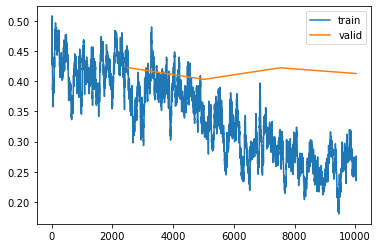

In [60]:
learn.recorder.plot_loss()

Der Graph deutet an, dass nach der zweiten Epoch ein Overfitting stattfindet, da der Valuationloss ansteigt. In den darauffolgenden Trainingsepochs sinkt der Losswert jedoch wieder. Ansteigende Valuationlosswerte deuten auf ein Overfitting des Modells hin. Sinkt der Validationloss ist dies ein Zeichen dafür, dass das Modell noch Underfitted ist.

#### Evaluation des Modells mit dem Testset
Das Modell kann anschließend über die `validate` Methode evaluiert werden. Dafür wird der DataLoader des Testdatensatz übergeben. Als Ausgabe erhält man die berechneten Metriken zurück:

In [61]:
learn.validate(dl=dls_test.valid)

(#5) [0.4483986794948578,0.8185417056083679,0.7699760400566235,0.7995446846202856,0.7814266758970808]

#### Trainieren eines Modells mit mehr Schritten beim Gradual Unfreezing
In diesem Abschnitt soll getestet werden, ob mit weiteren Unfreezing Schritten eine bessere Modellperformance erreicht werden kann.

In [48]:
# Erzeugen einer neuen Modellinstanz
_, _, _, hf_model2 = BLURR_MODEL_HELPER.get_hf_objects(model_checkpoint, task=hf_task,config_kwargs={'num_labels': num_labels})

model2 = HF_BaseModelWrapper(hf_model2)

learn2 = Learner(dls, 
                model2,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy,Recall(average='macro'),Precision(average="macro"),F1Score(average="macro")],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()
learn2.create_opt()
learn2.freeze()

Nachdem der zweite Learner erzeugt wurde und alle Layer eingefroren wurden, kann auch hier die LR gesucht werden.

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.013182567432522774)

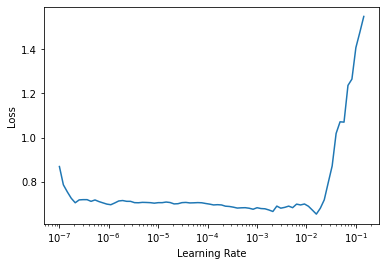

In [49]:
learn2.lr_find()

Der LR-Finder schlägt eine LR von 1E-3 vor. Anhand des Plots kann bestätigt werden, dass diese LR geeignet ist. 
Der finale Layer des Modells wird anschließend mit dieser LR trainiert.

In [50]:
learn2.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.440438,0.433121,0.802154,0.767571,0.790023,0.775975,02:18


Dieses Modell erreicht bereits nach einer Epoch eine Accuracy von 80,21%.

Anschließend kann das Modell mit der Methode freeze_to() stufenweise unfreezed werden, um immer mehr Parametergruppen zusammen zutrainieren (Gradual Unfreezing):

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.3182567499825382e-06)

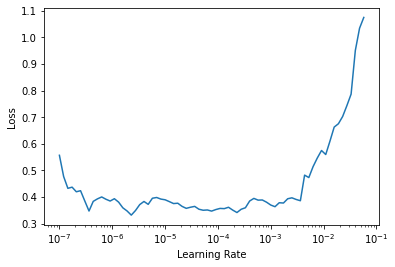

In [53]:
learn2.freeze_to(-2)
learn2.lr_find()

Da der Learning Rate Finder bei Transformer Modellen eine Tendenz zu sehr kleinen LRs hat, wird eher der Graph zu Ermittlung einer geeigneten LR von mir verwendet. Im zweiten Trainingsschritt werden die entfrorenen Layer mit einer etwas agressiveren LR von 1E-4 (finaler Layer) für eine Epoch trainiert:

Die Verwendung der `slice`-Syntax erlaubt es den ersten Wert für die ersten Layer des Modells zu verwenden und den zweiten für den finalen Layer. Die Layer dazwischen erhalten gleichverteilte LR zwischen den beiden Parameterwerten. \
Das der erste Wert durch 2.6**4 geteilt wird, ist eine Empfehlung aus dem Buch "Deep Learning for Coders with fastai and PyTorch" S.349

In [54]:
learn2.fit_one_cycle(1,slice(1e-4/2.6**4,1e-4))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.401223,0.432453,0.799761,0.766979,0.786034,0.774370,02:19


Anschließend wird erneut ein weiterer Layer des Modelles entfroren und die LR bestimmt:

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

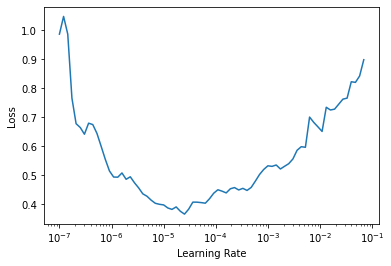

In [58]:
learn2.freeze_to(-3)
learn2.lr_find()

In [59]:
learn2.fit_one_cycle(1,slice(2e-6/2.6**4,2e-6))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.339794,0.432362,0.801356,0.764679,0.790399,0.773945,03:36


Da es keine weiteren Parametergruppen mehr gibt kann nun das gesamte Modell unfreezed werden. Anschließend wird wieder die LR bestimmt und das Modell für weitere Epochs 4 trainiert.

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=6.309573450380412e-07)

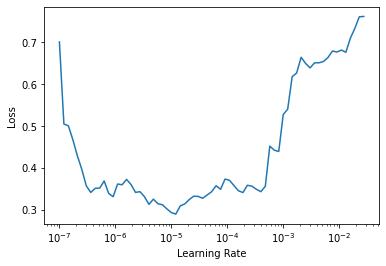

In [67]:
learn2.unfreeze()
learn2.lr_find()

In [68]:
learn2.fit_one_cycle(4,slice(2e-6/2.6**4,2e-6))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.426803,0.426179,0.802952,0.772231,0.788828,0.778891,03:40
1,0.419079,0.428867,0.804946,0.766452,0.796322,0.776819,03:41
2,0.345022,0.421650,0.804946,0.774282,0.791204,0.781064,03:44
3,0.306573,0.422114,0.806941,0.774818,0.794433,0.782460,03:44


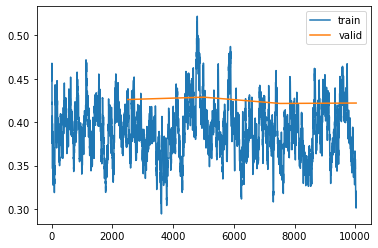

In [70]:
learn2.recorder.plot_loss()

In [71]:
learn2.validate(dl=dls_test.valid)

(#5) [0.44751060009002686,0.7970966696739197,0.7441110560882767,0.7727761804364692,0.7548701100166129]

Da noch kein Overfitting stattgefunden hat, kann noch weiter trainiert werden.
Hierfür wird die Standard Learning Rate für Transformer Modelle von 2E-5 verwendet.

In [72]:
learn2.fit_one_cycle(4,slice(2e-5/2.6**4,2e-5))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.382783,0.421788,0.811328,0.774178,0.803441,0.784539,03:40
1,0.354537,0.404302,0.819705,0.791532,0.807639,0.798164,03:42
2,0.316706,0.411212,0.825688,0.794655,0.816818,0.803287,03:41
3,0.313272,0.414759,0.824491,0.795748,0.813780,0.803061,03:40


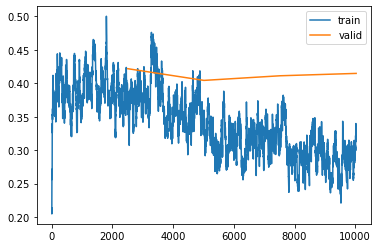

In [73]:
learn2.recorder.plot_loss()

Die ansteigende Valid Loss Kurve ist ein Indiz für Overfitting nach der zweiten Epoch, daher wird das Modell nicht weiter trainiert.

In [74]:
learn2.validate(dl=dls_test.valid)

(#5) [0.4519796073436737,0.8129330277442932,0.764214649079368,0.7920162004557623,0.7750384354843459]

Es konnte leider keine bessere Modellperformance durch die erweiterte Anwendung der Best Practice Methoden Gradual Unfreezing und Discriminative Fintuning erreicht werden.

#### Speichern des Models

In [62]:
learn.export(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

#### Anwendung des gespeicherten Modells
Um das gespeicherte Modell anzuwenden, muss dieses zunächst geladen werden: 

In [63]:
saved_model = load_learner(fname=f'./deepset_finetuned/offensive_language_deepset_{task}_standard_finetune_gem_germeval2019_split_makrof1_fastai.pkl')

Anschließend kann die `blurr_predict` Methode genutzt werden, um Vorhersagen zu generieren:

In [74]:
saved_model.blurr_predict("Unglaublich wie beschissen du heute gespielt hast @ThomasMüller")

[(('OTHER',), (#1) [tensor(1)], (#1) [tensor([0.4816, 0.5184])])]

In [75]:
saved_model.blurr_predict('''“Der Sozialismus ist eine Religion der Lüge. Ihre Glaubenssätze sind:
                            Neid und Missgunst, Hass und Verachtung, Faulheit und Mittelmäßigkeit, 
                            Raub und Diebstahl.” ― Roland Baader"''')

[(('OTHER',), (#1) [tensor(1)], (#1) [tensor([0.2270, 0.7730])])]